# Import library

In [612]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import datasketch
from tqdm import tqdm

import nltk

In [613]:
print(os.getcwd())
path = os.path.abspath(os.path.join(os.getcwd(), "../data"))
print(path)
# data_train = pd.read_csv(path + '/train.csv')
data_train = pd.read_csv(path + '/train.csv',index_col='id')


/Users/yusuke_sugihara/DA_Project1/DataAnalytics/Quora-question-pair-similarity
/Users/yusuke_sugihara/DA_Project1/DataAnalytics/data


# Preprocessing and Exploratory Data Analysis(Simple ver.)

In [614]:
print(data_train.shape)
print(data_train.head())

(404290, 5)
    qid1  qid2                                          question1  \
id                                                                  
0      1     2  What is the step by step guide to invest in sh...   
1      3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2      5     6  How can I increase the speed of my internet co...   
3      7     8  Why am I mentally very lonely? How can I solve...   
4      9    10  Which one dissolve in water quikly sugar, salt...   

                                            question2  is_duplicate  
id                                                                   
0   What is the step by step guide to invest in sh...             0  
1   What would happen if the Indian government sto...             0  
2   How can Internet speed be increased by hacking...             0  
3   Find the remainder when [math]23^{24}[/math] i...             0  
4             Which fish would survive in salt water?             0  


In [615]:
print(data_train.sample(10, random_state=10))

          qid1    qid2                                          question1  \
id                                                                          
108281  177958  177959  How can I get more information on cryptocurrency?   
365075  165259  495170  How much does each miner in Gold Rush: Alaska ...   
399424  110838  408590  Can a stock exchange be listed in another stoc...   
116651  189968  189969  What is the top speed of the quickest football...   
251097    6403   53276       Is there any way of knowing if a guy is gay?   
220896  310761   60581         Which is the best laptop to buy under 22k?   
236047  346878  346879  Can I press charges against someone who keeps ...   
321985  299182    3976  Which are the famous tourist places in Chhatti...   
377916   76930   84506  Is there a difference between native mini disp...   
387985  304668  175705  How can I contact Instagram regarding my hacke...   

                                                question2  is_duplicate  
i

In [616]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404290 entries, 0 to 404289
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          404290 non-null  int64 
 1   qid2          404290 non-null  int64 
 2   question1     404289 non-null  object
 3   question2     404288 non-null  object
 4   is_duplicate  404290 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 18.5+ MB


In [617]:
# Check for null values in question 1
data_train[~data_train['question1'].apply(lambda question: type(question) == str)]

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [618]:
# Check for null values in question 2
data_train[~data_train['question2'].apply(lambda question: type(question) == str)]

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
105780,174363,174364,How can I develop android app?,NaN,0
201841,303951,174364,How can I create an Android app?,NaN,0


In [619]:
data_train = data_train.dropna(how="any").reset_index(drop=True)
data_train.shape

(404287, 5)

In [620]:
data_train['is_duplicate'].value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

/Users/yusuke_sugihara/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_duplicate', ylabel='count'>

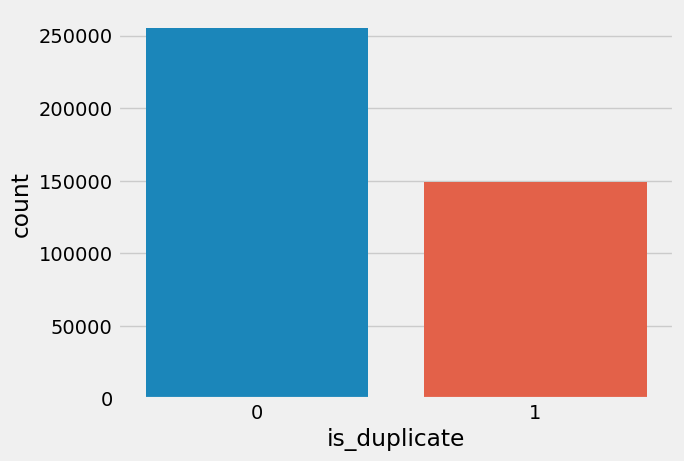

In [621]:
sns.countplot(data_train['is_duplicate'])

In [622]:
data_train = data_train.sample(20000, random_state=10)
print(data_train.head())

          qid1    qid2                                          question1  \
306834  430440  430441  In the US, rather than raise the minimum wage,...   
141915  225177  225178  Why is Thailand's total fertility rate so low ...   
176530  271587  271588            What does having a bad job mean to you?   
55241    64010   97413        What is fast adder and why it is called so?   
98694   163966  163967             Should my partner and I just break up?   

                                                question2  is_duplicate  
306834  What is the minimum wage in US. Who all are su...             0  
141915       Why are employment rates in Thailand so low?             0  
176530  Will I be able to get a job an actuary if I ha...             0  
55241   Picasa: Why is Picasa's picture loading speed ...             0  
98694          How do I earn money from a wordpress blog?             0  


In [623]:
com_data_train = data_train['question1'].append(data_train['question2']).reset_index()
print(com_data_train.head())


    index                                                  0
0  306834  In the US, rather than raise the minimum wage,...
1  141915  Why is Thailand's total fertility rate so low ...
2  176530            What does having a bad job mean to you?
3   55241        What is fast adder and why it is called so?
4   98694             Should my partner and I just break up?


/var/folders/11/4w81_8697d9g_9c3944_ytwh0000gn/T/ipykernel_2687/2003987698.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  com_data_train = data_train['question1'].append(data_train['question2']).reset_index()


In [624]:
com_data_train.drop(['index'],axis=1,inplace=True)
com_data_train.columns = ['question']

In [625]:
print(com_data_train.head())

                                            question
0  In the US, rather than raise the minimum wage,...
1  Why is Thailand's total fertility rate so low ...
2            What does having a bad job mean to you?
3        What is fast adder and why it is called so?
4             Should my partner and I just break up?


In [626]:
print(com_data_train.shape)

(40000, 1)


In [627]:
# making a dictionary mapping a question to its duplicate question
correct = data_train[data_train['is_duplicate']==1]
correct_dict = {}
for x,y in zip(correct['question1'],correct['question2']):
    if correct_dict.get(x)==None:
        correct_dict[x] = [y]
    else:
        correct_dict[x].append(y)
        correct_dict[x] = [i for i in set(correct_dict[x])]
for x,y in zip(correct['question2'],correct['question1']):
    if correct_dict.get(x)==None:
        correct_dict[x] = [y]
    else:
        correct_dict[x].append(y)
        correct_dict[x] = [i for i in set(correct_dict[x])]

In [628]:
# Set Representation
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from tqdm import tnrange, tqdm_notebook
from datasketch import MinHash, MinHashLSH
from tqdm import tqdm

set_dict={} # maps question id (eg 'm23') to set representation of question
norm_dict={} # maps question id (eg 'm23') to actual question. May use this dictionary to evaluate results of LSH output.
count=1
for question in tqdm_notebook([x for x in com_data_train['question'] if type(x)==str]):
    temp_list = []
    for shingle in question.split(' '):
        if shingle not in stop_words:
            temp_list.append(shingle.lower())
    set_dict["m{0}".format(count)] = set(temp_list)
    norm_dict["m{0}".format(count)] = question
    count +=1

/var/folders/11/4w81_8697d9g_9c3944_ytwh0000gn/T/ipykernel_2687/3385088640.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for question in tqdm_notebook([x for x in com_data_train['question'] if type(x)==str]):


  0%|          | 0/40000 [00:00<?, ?it/s]

In [629]:
# Create minHash signatures
num_perm = 256
min_dict = {} # maps question id (eg 'm23') to min hash signatures
count2 = 1
for val in tqdm_notebook(set_dict.values()): 
    m = MinHash(num_perm=num_perm)
    for shingle in val:
        m.update(shingle.encode('utf8'))
    min_dict["m{}".format(count2)] = m
    count2+=1

/var/folders/11/4w81_8697d9g_9c3944_ytwh0000gn/T/ipykernel_2687/2750401366.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for val in tqdm_notebook(set_dict.values()):


  0%|          | 0/40000 [00:00<?, ?it/s]

In [630]:
# Create LSH index
lsh = MinHashLSH(threshold=0.4, num_perm=num_perm)
for key in tqdm_notebook(min_dict.keys()):
    lsh.insert(key,min_dict[key])

/var/folders/11/4w81_8697d9g_9c3944_ytwh0000gn/T/ipykernel_2687/588069337.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(min_dict.keys()):


  0%|          | 0/40000 [00:00<?, ?it/s]

In [631]:
def create_cand_pairs():
    big_list = []
    for query in min_dict.keys():
        bucket = lsh.query(min_dict[query])
        if len(bucket)==1:
            big_list.append([bucket[0],"None"])
        if len(bucket)>1:
            first_val = bucket[0]
            for val in bucket[1:]:
                second_val = val
                big_list.append([first_val,second_val])
    return big_list

In [632]:
cand_pairs = create_cand_pairs()

In [638]:
def evaluation(cand_pairs):
    tp = 0
    fp = 0
    fn = 0
    for pair in cand_pairs:
        if pair[1] == "None":
            if str(norm_dict[pair[0]]) in correct_dict.keys():
                    fn +=1
        else:
            if isinstance(correct_dict.get(norm_dict[pair[0]]), (list,)):
                if norm_dict[pair[1]] in correct_dict.get(norm_dict[pair[0]]):
                    tp +=1
                else:
                    fp +=1
                    
    precision = tp/(fp+tp)
    recall = tp/(fn+tp)
    print ('precision is {:.2f}'.format(precision))
    print ('recall is {:.2f}'.format(recall))

In [639]:
evaluation(cand_pairs)

precision is 0.02
recall is 0.83
